# Memetic Algorithm for Order Batching Problem

In [484]:
import random
import matplotlib.pyplot as plt

1. Generate orders, Individuals, Decode individual to batches

In [485]:
# variable orders is a list,  has object_num amount of objects
# Each object is represented by a tuple (id, weight, and aisle number), weight is between [1,5]
# Each aisle has 20 objects
def generate_orders(object_num, order_num):
    id = list(range(1,object_num+1))
    weights = random.choices(list(range(1, 6)), k = object_num) # weight of each order
    aisles = [(i-1)//20 +1 for i in id] # aisle number of each order
    objects = list(zip(id, weights, aisles))
    # Generate batch_num amount of batches
    orders = []
    k = random.choices(list(range(5,11)), k=10) # number of orders in a batch
    selected = random.sample(objects, 100) # randomly select 100 orders
    for i in range(order_num):
        order = selected[sum(k[:i]):sum(k[:i+1])]
        orders.append(order)
    return orders

# Swarm is a list, has k individuals
def generate_swarm(order_num,k):
    order_id = list(range(order_num))
    swarm = []
    for i in range(k):
        random.seed()
        random.shuffle(order_id)
        individual = order_id.copy()
        swarm.append(individual)
    return swarm

# batches is a list
def decode(individual,orders,capacity):
    load = 0
    batches = []
    # Generate batches
    batch = []
    for i in range(len(individual)):
        order = orders[individual[i]]
        load_i = sum([j[1] for j in order])
        if load + load_i < capacity:
            load += load_i
            batch.append(order)
        else:
            batches.append(batch)
            batch = []
            batch.append(order)
            load = load_i
    batches.append(batch)
    # Flatten and Sort orders in each batch by object number
    for k in range(len(batches)):
        batches[k] = sorted([i for order in batches[k] for i in order], key = lambda x: x[0])
    return batches

2. Distance and fitness Function for individuals

In [486]:
# Distance between two objects is 1 unit
# Distance between two aisles is 4 units
def distance(individual,orders,capacity):
    batches = decode(individual,orders,capacity)
    # Calculate paased aisles for each batch
    aisles = []
    for batch in batches:
        aisle = list(set([x[2] for x in batch]))
        aisles.append(aisle)
    # Calculate distance
    horizental_distance, vertical_distance = 0, 0
    for i,aisle in enumerate(aisles):
        horizental_distance += aisle[-1] * 4 + 4/2
        if len(aisle) % 2 == 0: # if this batch cross even number of aisles
            vertical_distance += (1 + 10 + 1) * len(aisle)
        else:
            vertical_distance += (1 + 10 + 1) * (len(aisle) - 1)
            last_aisle = (batches[i][-1][0] - (aisle[-1]-1)*20) % 10
            last_aisle = 10 if last_aisle == 0 else last_aisle
            vertical_distance += last_aisle * 2 # the travel distance in the last aisle
    distance = horizental_distance + vertical_distance
    return distance

def fitness(individual,orders,capacity):
    dist = distance(individual,orders,capacity)
    individual_num = len(individual)
    cost = dist + individual_num * 100
    return 1/cost

3. Perturbation functions: Crossover, Mutation ,Local Search

In [487]:
# Partially mapped crossover
def PMX(parents):
    I1,I2 = parents[0],parents[1]
    i, j = sorted(random.sample(range(len(I1)-1), 2))
    offspring = I2.copy()
    offspring[i:j+1] = I1.copy()[i:j+1]
    for k in range(i,j+1):
        if I2[k] not in offspring:
            idx = I2.index(I1[k])
            while i<=idx<=j:
                idx = I2.index(I1[idx])
            offspring[idx] = I2[k]
    return offspring

def tournament_selection(population,orders,capacity,tournament_size,k):
    winner = []
    for i in range(k):
        participent = random.sample(population,tournament_size)
        selected = max(participent, key = lambda x: fitness(x,orders,capacity))
        winner.append(selected)
    return winner

def mutation(individual):
    i, j = sorted(random.sample(range(len(individual)-1), 2))
    individual[i], individual[j] = individual[j], individual[i]
    return individual

def local_search(individual,orders,capacity):
    n = len(individual)
    dist = distance(individual,orders,capacity)
    #remove one order from the individual
    cost = []
    for i in range(n):
        I = individual.copy()
        I.remove(individual[i])
        new_dist = distance(I,orders,capacity)
        delta_dist = dist - new_dist
        cost.append(delta_dist)
    x,y = sorted(range(n), key = lambda x: cost[x])[0], sorted(range(n), key = lambda x: cost[x])[1]
    # repair the individual
    I = individual.copy()
    I.remove(individual[x])
    I.remove(individual[y])
    #insert x
    cost = []
    destructed_distace = distance(I,orders,capacity)
    for i in range(len(I)):
        new_I = I.copy()
        new_I.insert(i,individual[x])
        new_dist = distance(new_I,orders,capacity)
        delta_dist = new_dist - destructed_distace
        cost.append(delta_dist)
    z = sorted(range(len(I)), key = lambda x: cost[x])[0]
    I.insert(z,individual[x])
    #insert y
    cost = []
    destructed_distace = distance(I,orders,capacity)
    for i in range(len(I)):
        new_I = I.copy()
        new_I.insert(i,individual[y])
        new_dist = distance(new_I,orders,capacity)
        delta_dist = new_dist - destructed_distace
        cost.append(delta_dist)
    z = sorted(range(len(I)), key = lambda x: cost[x])[0]
    I.insert(z,individual[y])
    return I

def batch_plan(orders,best_ind,capacity,batches):
    #Print batch Plan
    for i,order in enumerate(orders):
        l = [x[0] for x in order]
        print('order {}:'.format(i),l)
    batches = decode(best_ind,orders,capacity)
    order_num = []
    for i,batch in enumerate(batches):
        l = []
        for j in range(len(orders)):
            if orders[j][0] in batch:
                l.append('order {}'.format(j))
        order_num.append(l)
    for i in range(len(order_num)):
        print('batch {}:'.format(i),order_num[i])


4. Main Function

order 0: [362, 178, 20, 206, 87]
order 1: [325, 166, 189, 245, 96, 79, 32, 358]
order 2: [201, 256, 56, 229, 137, 215, 258, 196, 238]
order 3: [175, 197, 369, 293, 3, 93, 194, 205]
order 4: [304, 226, 311, 1, 111, 186]
order 5: [75, 296, 181, 165, 399]
order 6: [98, 392, 15, 291, 327, 134]
order 7: [24, 106, 247, 132, 398, 385, 84]
order 8: [22, 370, 268, 39, 102]
order 9: [200, 377, 230, 149, 71, 68, 8, 280, 347]
batch 0: ['order 2', 'order 4', 'order 8']
batch 1: ['order 0', 'order 3', 'order 9']
batch 2: ['order 1', 'order 5', 'order 6', 'order 7']
Total Distance: 688.0


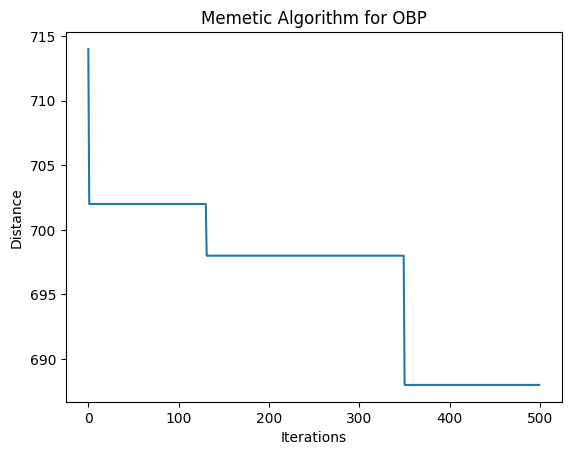

In [488]:
object_num = 400
order_num = 10
capacity = 80
k = 10
orders = generate_orders(object_num,order_num)
swarm = generate_swarm(order_num,k)
batches = decode(swarm[0],orders,capacity)
epochs = 500
iterations = []
best_ind = swarm[0]
for ep in range(epochs):
    # Crossover
    parents = tournament_selection(swarm,orders,capacity,8,2)
    offspring = PMX(parents)
    swarm.append(offspring)
    swarm = sorted(swarm, key = lambda x: fitness(x,orders,capacity))[1:]
    #Mutation
    if random.random() < 0.1:
        idx = random.randint(0,k-1)
        mutation(swarm[-1])
    if ep>100 and iterations[-1] == iterations[-10]:
        mutation(swarm[-1])
    # Local Search
    if random.random() < 0.3:
        idx = random.randint(0,k-1)
        swarm[idx] = local_search(swarm[idx],orders,capacity)
    #Update best individual
    if fitness(swarm[-1],orders,capacity) > fitness(best_ind,orders,capacity):
        best_ind = swarm[-1]
    iterations.append(distance(best_ind,orders,capacity))
#Print batch Plan
batch_plan(orders,best_ind,capacity,batches)
print('Total Distance:',distance(best_ind,orders,capacity))
#Plot the convergence curve
plt.plot(iterations)
plt.xlabel('Iterations')
plt.ylabel('Distance')
plt.title('Memetic Algorithm for OBP')
plt.show()

References:  
[1]	"[Batching orders in warehouses by minimizing travel distance with genetic algorithms](https://www.sciencedirect.com/science/article/pii/S0166361504000995)," Computers in Industry, vol. 56, no. 2, 2005/02/01, doi: 10.1016/j.compind.2004.06.001.
